In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf

def get_price_data(ticker):
  data = yf.download(ticker, start=start_date, end=end_date)
  data = pd.DataFrame({"close": data['Close']})
  return data

start_date = "2014-01-01"
end_date = "2024-01-01"

ticker_list = [['MS', 'GS'], ['BAC', 'PNC'], ['MRO', 'MUR'], ['STWD', 'ARI'], ['STWD', 'TWO'], ['DX', 'IVR'], ['PXD', 'EOG']]
ticker = ['MS', 'GS'] #p-value = 0.0112
#ticker = ['BAC', 'PNC'] #p-value = 0.0165
#ticker = ['MRO', 'MUR']
#ticker = ['STWD', 'ARI'] #p-value = 0.15
#ticker = ['STWD', 'TWO'] #p-value = 0.052

#ticker = ['DX', 'IVR']
#ticker = ['PXD', 'EOG']


stock1 = get_price_data(ticker[0])
stock2 = get_price_data(ticker[1])

df = pd.merge(stock1, stock2, left_index=True, right_index=True, suffixes=('_Stock1', '_Stock2'))
df = df.rename(columns={'close_Stock1': 'Stock1_close', 'close_Stock2': 'Stock2_close'})
#df['Stock1_return'] = df['Stock1_close'].pct_change()
#df['Stock2_return'] = df['Stock2_close'].pct_change()

#df['high_Stock1_return'] = df['high_Stock1']/df['Stock1_close'].shift(1)

#df['high_Stock2_return'] = df['high_Stock2']/df['Stock2_close'].shift(1)
df=df.dropna(how = "any")
df






[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Stock1_close,Stock2_close
Date,,
2014-01-02,31.030001,176.889999
2014-01-03,31.510000,178.149994
2014-01-06,31.620001,179.369995
2014-01-07,31.520000,178.289993
2014-01-08,31.559999,178.440002
...,...,...
2023-12-22,92.410004,380.649994
2023-12-26,92.839996,381.609985
2023-12-27,93.660004,384.480011


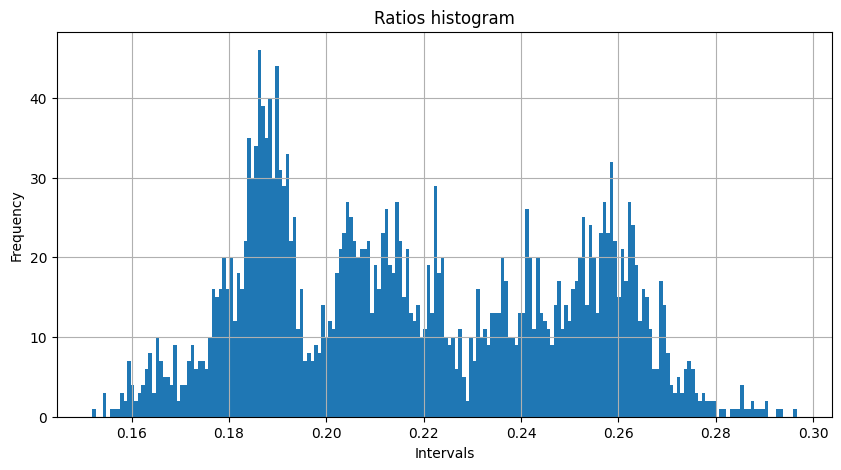

In [ ]:
def getRatios(df, plotOrNot):
    S1 = df['Stock1_close']
    S2 = df['Stock2_close']
    ratios = S1 / S2
    if plotOrNot:
        plt.figure(figsize=(10,5))
        ratios.hist(bins = 200)
        plt.title("Ratios histogram")
        plt.ylabel('Frequency')
        plt.xlabel('Intervals')
        plt.show()
    return S1, S2, ratios

S1, S2, ratios = getRatios(df, 1)



In [ ]:
from statsmodels.tsa.stattools import coint

_, pv_coint, _ = coint(df['Stock1_close'], df['Stock2_close'])
print("Cointegration pvalue : %0.4f"%pv_coint)


Cointegration pvalue : 0.0112


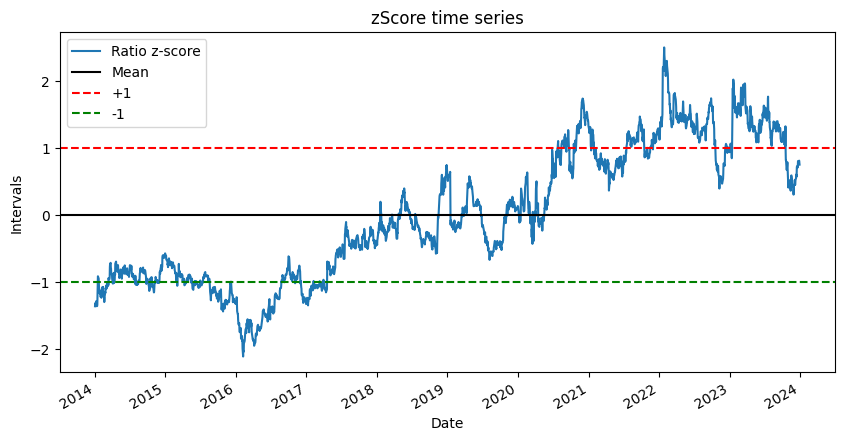

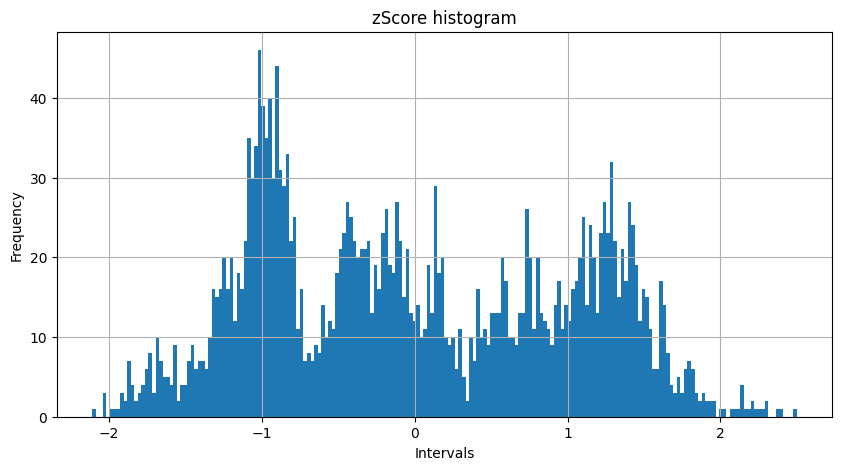

In [ ]:
def getZScore(ratios, plotOrNot):

    zScore = (ratios - ratios.mean()) / ratios.std()

    if plotOrNot:
        zScore.plot(figsize=(10,5))
        plt.axhline(zScore.mean(), color='black')
        plt.axhline(1.0, color='red', linestyle='--')
        plt.axhline(-1.0, color='green', linestyle='--')
        plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
        plt.title("zScore time series")
        plt.xlabel('Date')
        plt.ylabel('Intervals')

        plt.show()

        plt.figure(figsize=(10,5))
        zScore.hist(bins = 200)
        plt.title("zScore histogram")
        plt.ylabel('Frequency')
        plt.xlabel('Intervals')
        plt.show()
    return zScore

zScore = getZScore(ratios, 1)



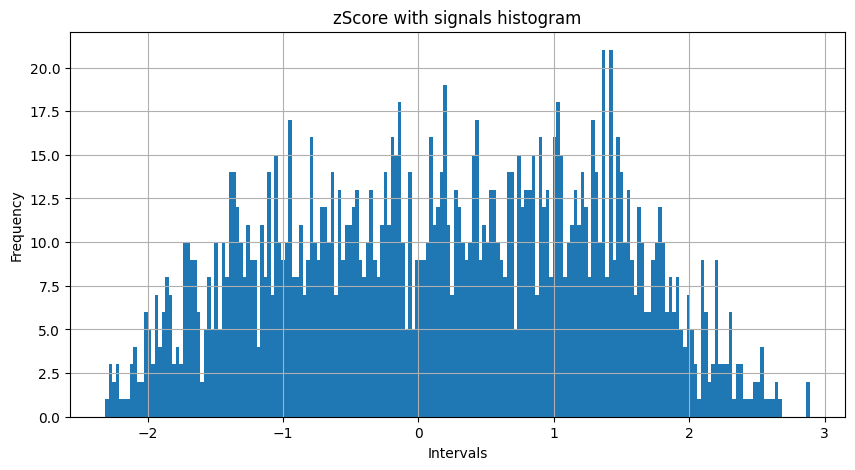

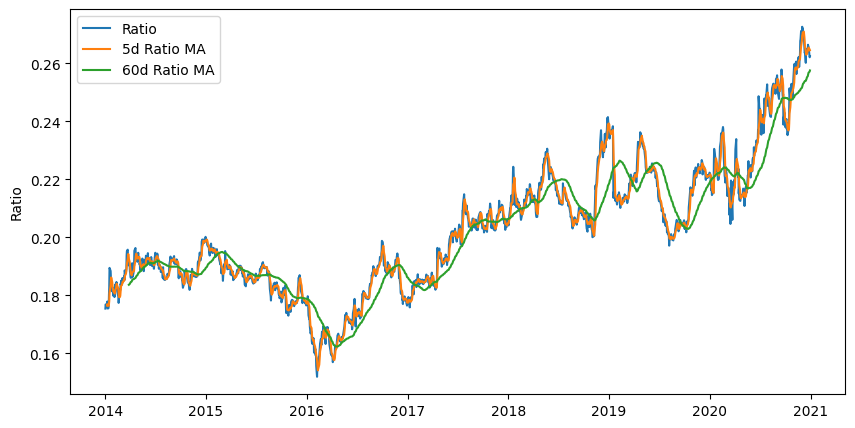

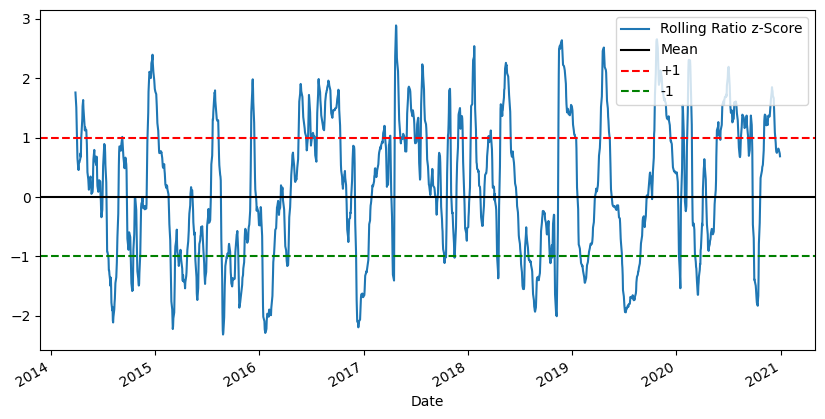

In [ ]:
def getMovingIndex(ratios, train_pct, w1, w2, plotOrNot):
    ### w1 < w2，拆分训练集+验证集，训练集的比例是train_pct
    length = len(ratios)
    trainLength = int(train_pct * length)
    train = ratios[:trainLength]
    test = ratios[trainLength:]

    # 计算指标moving_average, moving_std，以及moving_z_score：这里可以使用gplearn！！
    # 希望通过moving_z_score找到信号
    ratios_mavg1 = train.rolling(window=w1, center=False).mean()
    ratios_mavg2 = train.rolling(window=w2, center=False).mean()
    std = train.rolling(window=w2, center=False).std()
    zscore_mv = (ratios_mavg1 - ratios_mavg2) / std

    if plotOrNot:
        plt.figure(figsize=(10,5))
        zscore_mv.hist(bins = 200)
        plt.title("zScore with signals histogram")
        plt.ylabel('Frequency')
        plt.xlabel('Intervals')
        plt.show()

        plt.figure(figsize=(10,5))
        plt.plot(train.index, train.values)
        plt.plot(ratios_mavg1.index, ratios_mavg1.values)
        plt.plot(ratios_mavg2.index, ratios_mavg2.values)
        plt.legend(['Ratio','%dd Ratio MA'%w1, '%dd Ratio MA'%w2])
        plt.ylabel('Ratio')
        plt.show()

        plt.figure(figsize=(10,5))
        zscore_mv.plot()
        plt.axhline(0, color='black')
        plt.axhline(1.0, color='red', linestyle='--')
        plt.axhline(-1.0, color='green', linestyle='--')
        plt.legend(loc='upper right', labels = ['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
        plt.show()
    return train, test, zscore_mv

train, test, zscore_mv = getMovingIndex(ratios, 0.7, 5, 60, 1)


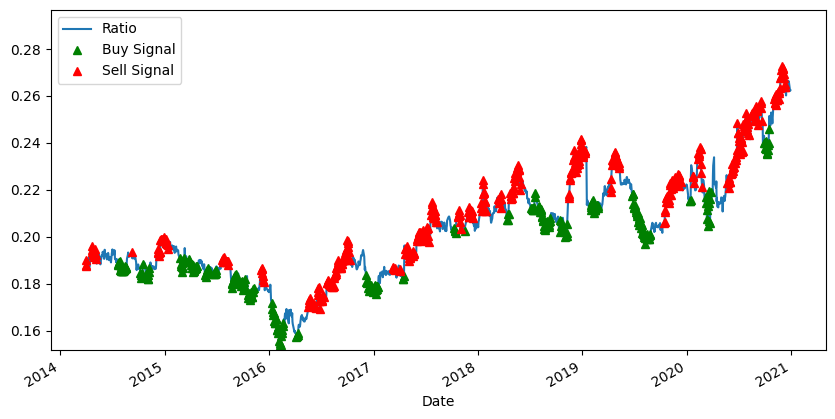

In [ ]:
def getTradeSignal(train, zscore_mv, w2, plotOrNot):
    # Plot the ratios and buy and sell signals from z score
    plt.figure(figsize=(10,5))

    train[w2:].plot()
    buy = train.copy()
    sell = train.copy()

    # 信号ratios = CU.SHF / SF.CZC，衍生出buy和sell。
    # 其他时候ratios = 0.
    buy[zscore_mv > -1] = 0
    sell[zscore_mv < 1] = 0

    if plotOrNot:
        buy[60:].plot(color='g', linestyle='None', marker='^')
        sell[60:].plot(color='r', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1,x2,ratios.min(),ratios.max()))
        plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
        plt.show()

    return buy, sell

buy, sell = getTradeSignal(train, zscore_mv, 60, 1)



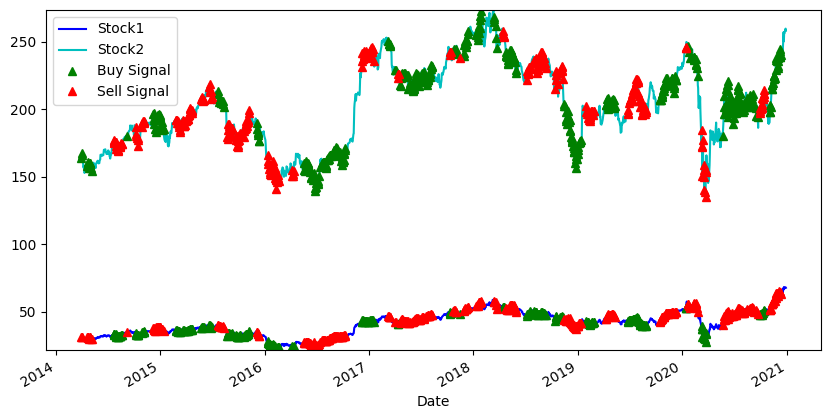

In [ ]:
def Trade2Contract(df, buy, sell, w2, plotOrNot):
    S1, S2, ratios = getRatios(df, 0)
    plt.figure(figsize=(10,5))
    S1 = S1.reindex(index = buy.index)
    S2 = S2.reindex(index = buy.index)
    S1[w2:].plot(color='b')
    S2[w2:].plot(color='c')

    # buyR和sellR先填充0。
    buyR = 0 * S1.copy()
    sellR = 0 * S1.copy()

    # 即buy只有在信号ratios<-1的时候保持ratios原值，此刻long S1=CU.SHF，short S2=SF.CZC
    buyR[buy!=0] = S1[buy!=0]
    sellR[buy!=0] = S2[buy!=0]

    # 即sell只有在信号ratios>1的时候保持ratios原值，此刻short S1=CU.SHF，long S2=SF.CZC。
    buyR[sell != 0] = S2[sell != 0]
    sellR[sell != 0] = S1[sell != 0]
    if plotOrNot:
      buyR[w2:].plot(color='g', linestyle='None', marker='^')
      sellR[w2:].plot(color='r', linestyle='None', marker='^')
      x1, x2, y1, y2 = plt.axis()
      plt.axis((x1, x2, min(S1.min(), S2.min()),max(S1.max(), S2.max())))

      plt.legend(['Stock1', 'Stock2', 'Buy Signal', 'Sell Signal'])
      plt.show()

Trade2Contract(df, buy, sell, 60, 1)



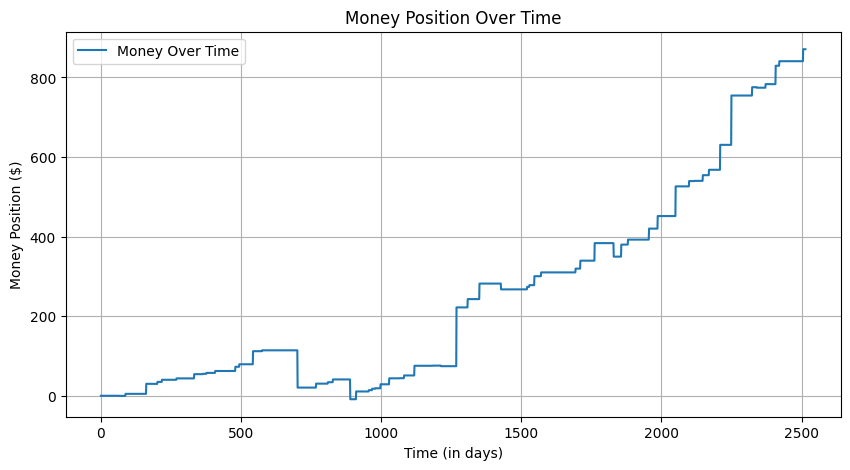

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def PairsTrade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    mv_ave1 = ratios.rolling(window=window1, center=False).mean()
    mv_ave2 = ratios.rolling(window=window2, center=False).mean()
    mv_std = ratios.rolling(window=window2, center=False).std()
    zscore = (mv_ave1 - mv_ave2) / mv_std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    money_history = []  # To track money over time

    for i in range(len(ratios)-1):
        # Calculate the positions and update money according to the logic
        if zscore[i] > 1:
            money += S1[i+1] - S2[i+1] * ratios[i+1]
            countS1 -= 1
            countS2 += ratios[i+1]
        elif zscore[i] < -1:
            money -= S1[i+1] - S2[i+1] * ratios[i+1]
            countS1 += 1
            countS2 -= ratios[i+1]
        elif abs(zscore[i]) < 0.5:  # Clear positions
            money += countS1 * S1[i+1] + countS2 * S2[i+1]
            countS1 = 0
            countS2 = 0

        money_history.append(money)  # Append current money to history after each trade

    return money, money_history

# Example usage, assuming S1 and S2 are defined and are Series of stock prices
# S1 = pd.Series([...])
# S2 = pd.Series([...])
money, money_history = PairsTrade(S1, S2, 5, 60)

# Plotting the money history
plt.figure(figsize=(10, 5))
plt.plot(money_history, label='Money Over Time')
plt.title('Money Position Over Time')
plt.xlabel('Time (in days)')
plt.ylabel('Money Position ($)')
plt.legend()
plt.grid(True)
plt.show()




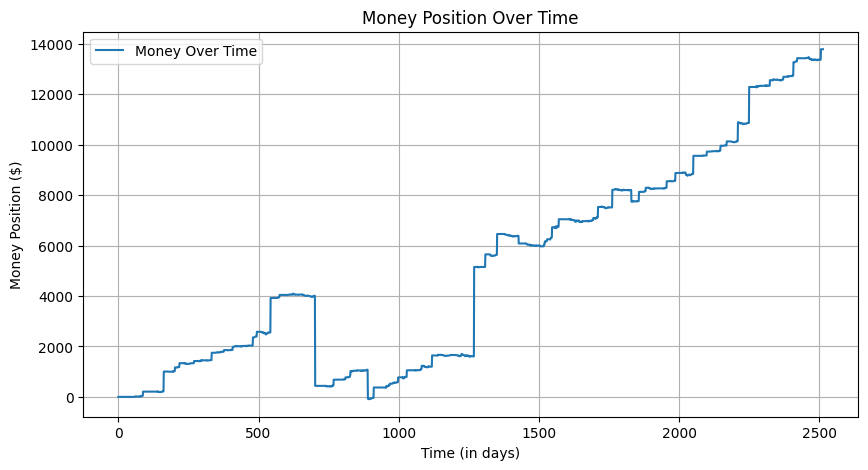

In [ ]:
def PairsTrade(S1, S2, window1, window2, investment_per_trade=10000):
    ratios = S1 / S2
    mv_ave1 = ratios.rolling(window=window1, center=False).mean()
    mv_ave2 = ratios.rolling(window=window2, center=False).mean()
    mv_std = ratios.rolling(window=window2, center=False).std()
    zscore = (mv_ave1 - mv_ave2) / mv_std

    money = 0
    countS1 = 0
    countS2 = 0
    money_history = []

    for i in range(len(ratios) - 2):
        # Calculate number of shares to trade based on fixed investment amount
        shares_s1 = investment_per_trade / S1[i+1]
        shares_s2 = investment_per_trade / S2[i+1]

        if zscore[i] > 1:
            money += shares_s1 * (S1[i+1] - S1[i+2]) + shares_s2 * (S2[i+2] - S2[i+1])
            countS1 -= shares_s1
            countS2 += shares_s2
        elif zscore[i] < -1:
            money += shares_s1 * (S1[i+2] - S1[i+1]) + shares_s2 * (S2[i+1] - S2[i+2])
            countS1 += shares_s1
            countS2 -= shares_s2
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i+1] + countS2 * S2[i+1]
            countS1 = 0
            countS2 = 0

        money_history.append(money)

    return money, money_history

# Example usage with $10,000 investment per trade
money, money_history = PairsTrade(S1, S2, 5, 60, 1000)

# Plotting the money history
plt.figure(figsize=(10, 5))
plt.plot(money_history, label='Money Over Time')
plt.title('Money Position Over Time')
plt.xlabel('Time (in days)')
plt.ylabel('Money Position ($)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
a = 'https://drive.google.com/file/d/1GiQMgb_zk3RgfG_ZlvkE9Jtb6qIhuM7u/view'
b = 'https://drive.google.com/file/d/1GiQMgb_zk3RgfG_ZlvkE9Jtb6qIhuM7u/view'

a==b

True

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming all your functions like get_price_data, getRatios, getZScore, getMovingIndex, getTradeSignal, Trade2Contract, and PairsTrade are defined properly

fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # Set up a 3x3 grid of plots
fig.tight_layout(pad=3.0)  # Add padding between plots

# Flatten the axes array for easy looping and initially hide all
axs = axs.flatten()
for ax in axs:
    ax.set_visible(False)

# List of indices in the 3x3 grid to place charts
# Choosing a balanced layout, here using the first 7 slots
plot_indices = [0, 1, 2, 3, 4, 5, 6]

for i, ticker in enumerate(ticker_list[:7]):  # Only iterate over the first seven pairs
    stock1 = get_price_data(ticker[0])
    stock2 = get_price_data(ticker[1])
    df = pd.merge(stock1, stock2, left_index=True, right_index=True, suffixes=('_Stock1', '_Stock2'))
    df = df.rename(columns={'close_Stock1': 'Stock1_close', 'close_Stock2': 'Stock2_close'})
    df = df.dropna(how="any")

    S1, S2, ratios = getRatios(df, 0)
    zScore = getZScore(ratios, 0)
    train, test, zscore_mv = getMovingIndex(ratios, 0.7, 5, 60, 0)
    buy, sell = getTradeSignal(train, zscore_mv, 60, 0)
    Trade2Contract(df, buy, sell, 60, 0)
    money, money_history = PairsTrade(S1, S2, 5, 60)

    # Set the current axis to visible and plot
    axs[plot_indices[i]].set_visible(True)
    axs[plot_indices[i]].plot(money_history, label='Money Over Time')
    axs[plot_indices[i]].set_title(f'Money Position Over Time for {ticker[0]} vs {ticker[1]}')
    axs[plot_indices[i]].set_xlabel('Time (in days)')
    axs[plot_indices[i]].set_ylabel('Money Position ($)')
    axs[plot_indices[i]].legend()
    axs[plot_indices[i]].grid(True)

# Display the plots
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


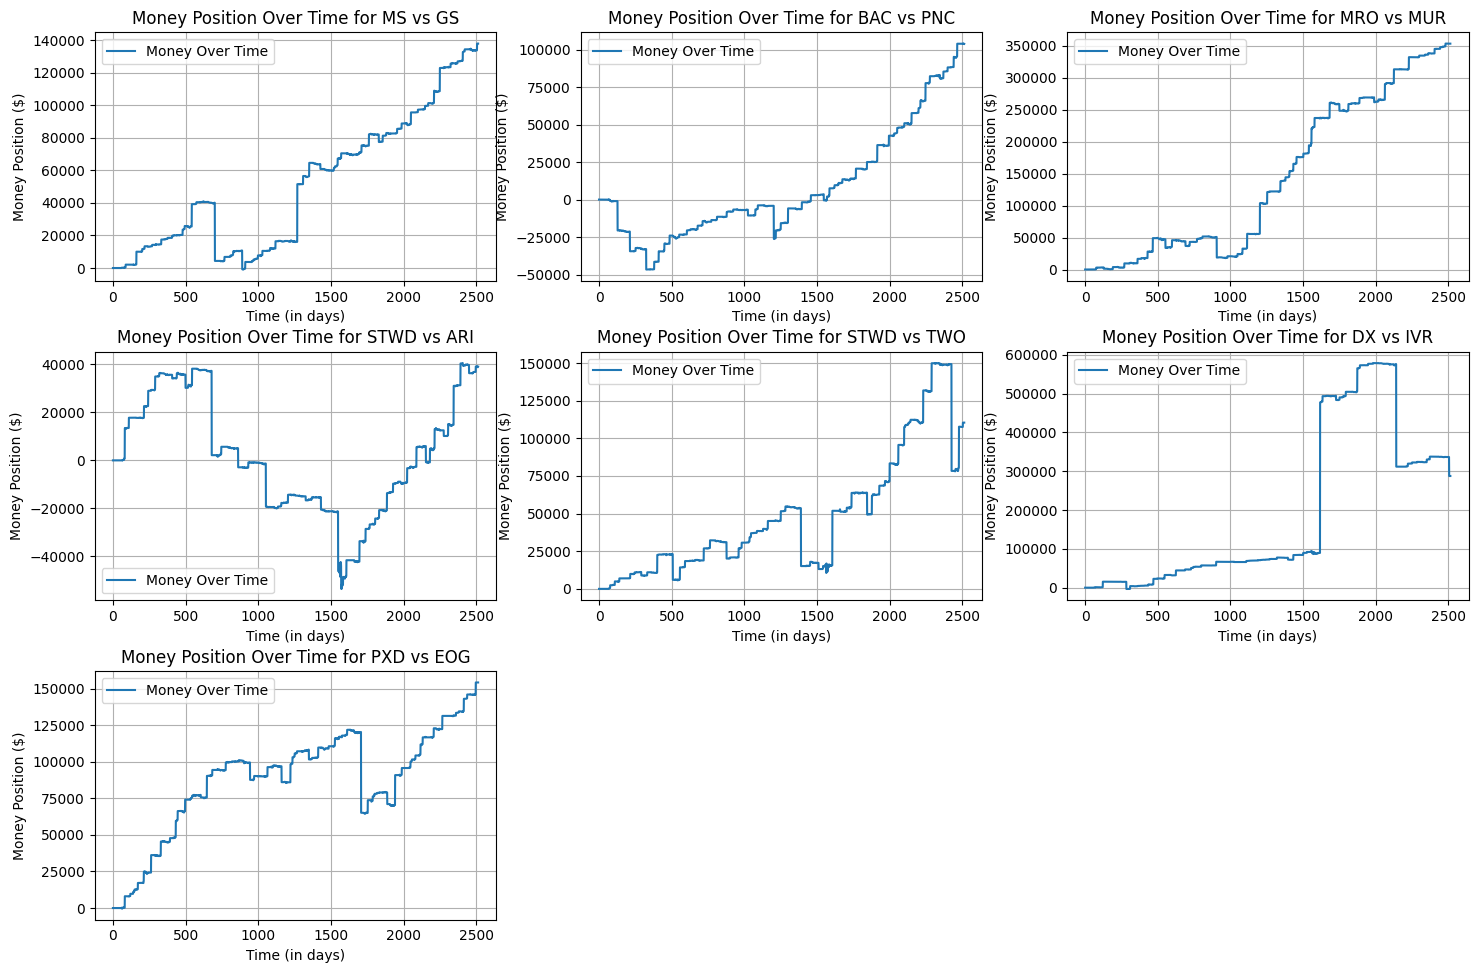

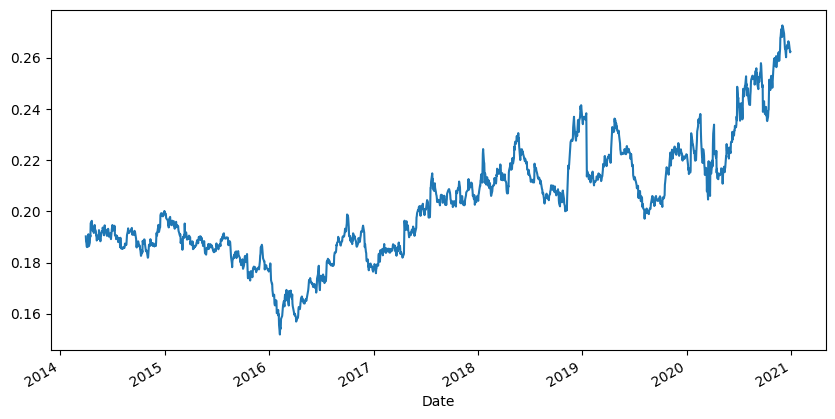

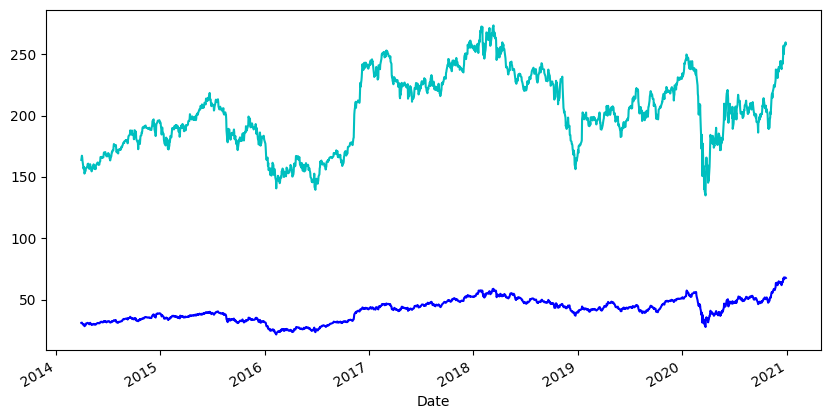

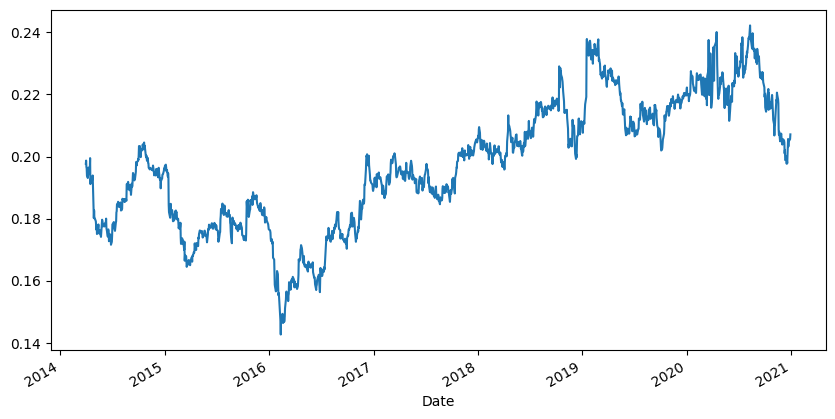

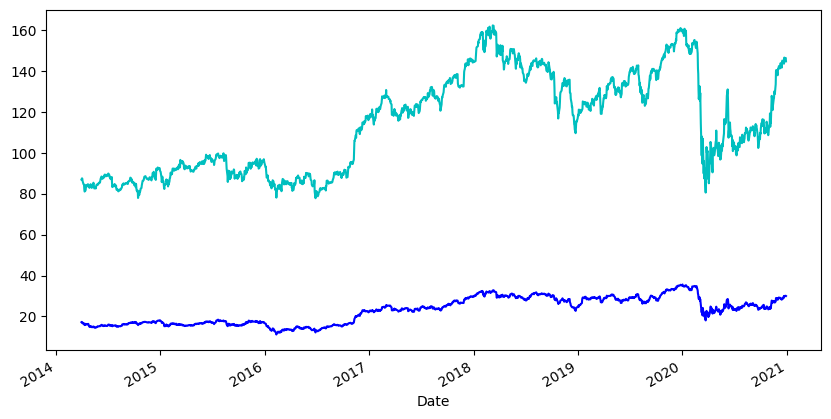

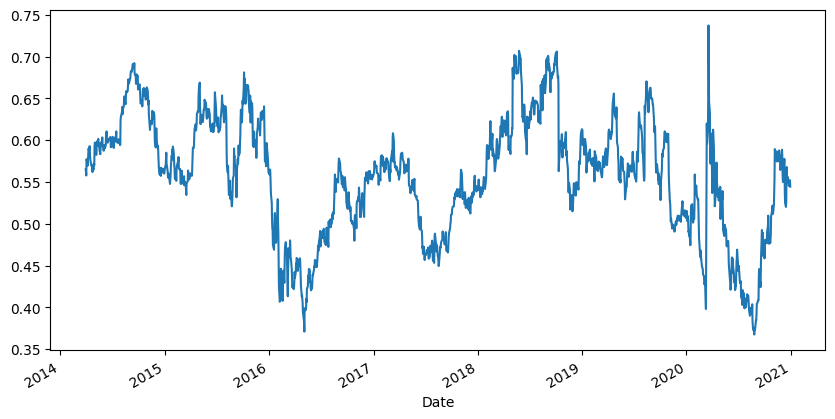

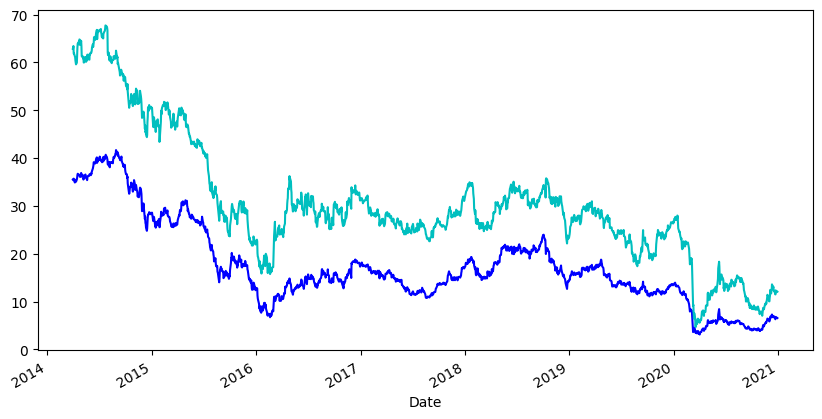

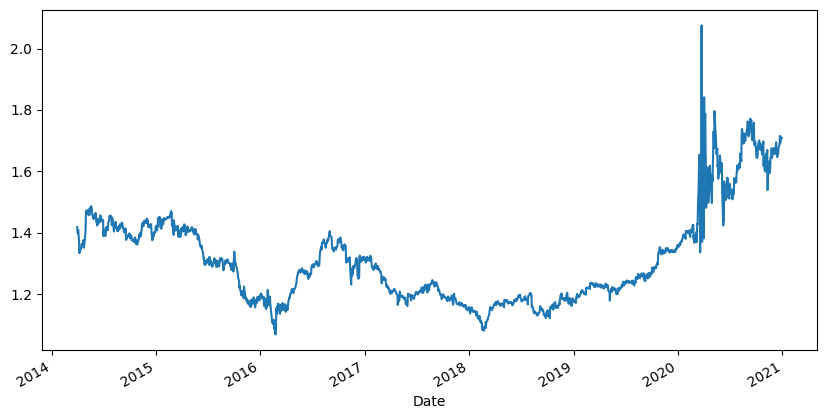

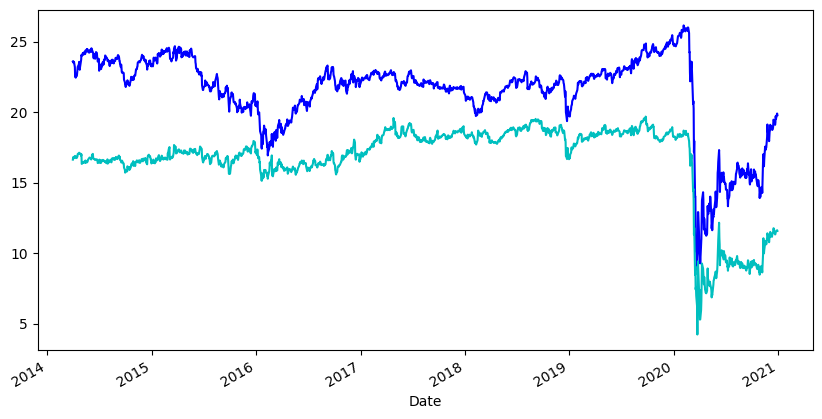

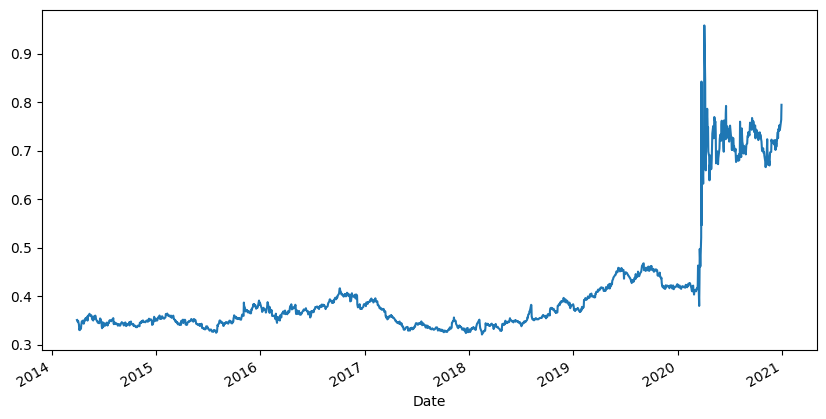

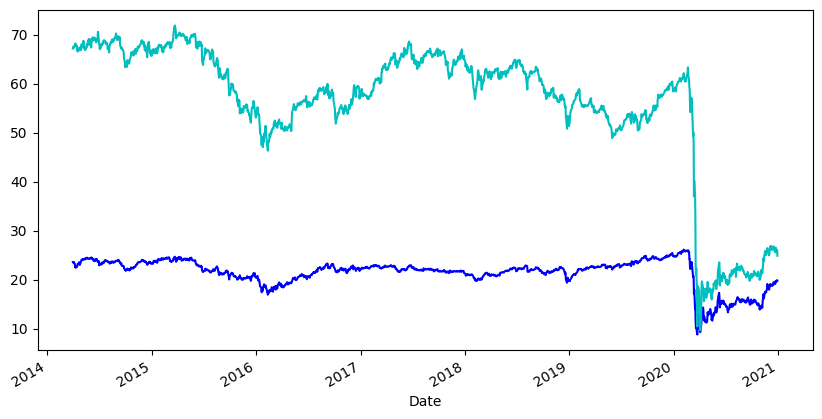

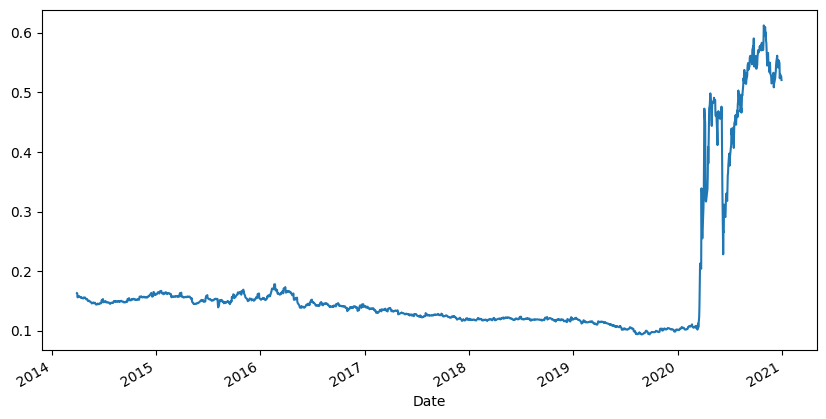

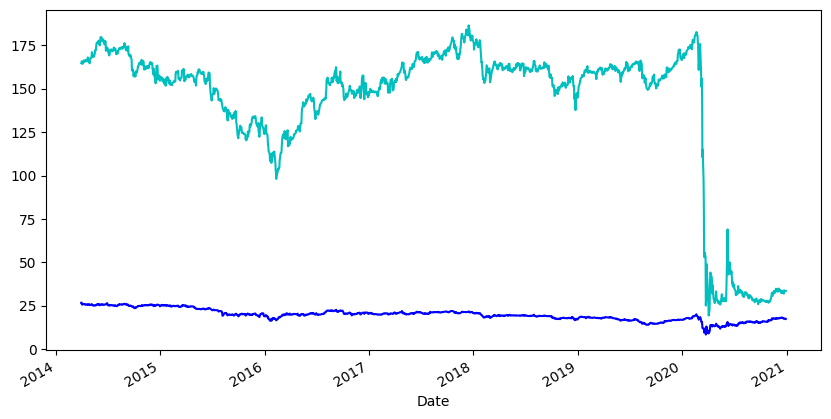

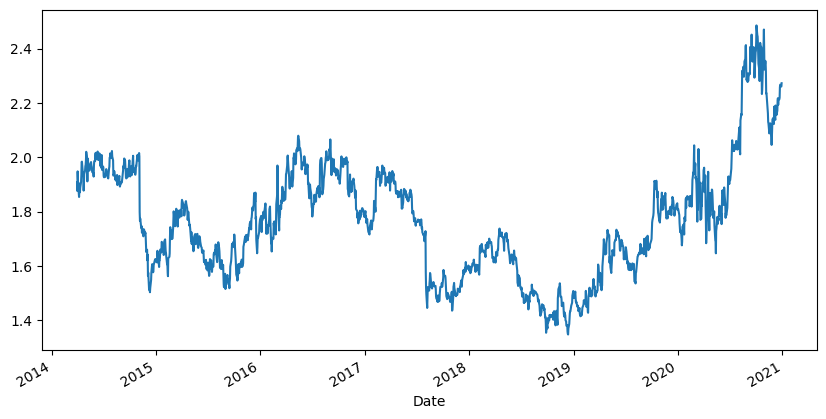

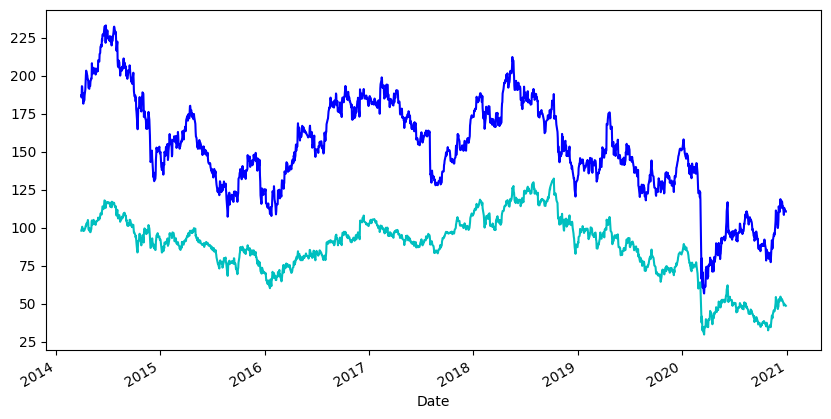

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming all your functions like get_price_data, getRatios, getZScore, getMovingIndex, getTradeSignal, Trade2Contract, and PairsTrade are defined properly

fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # Set up a 3x3 grid of plots
fig.tight_layout(pad=3.0)  # Add padding between plots

# Flatten the axes array for easy looping and initially hide all
axs = axs.flatten()
for ax in axs:
    ax.set_visible(False)

# List of indices in the 3x3 grid to place charts
# Choosing a balanced layout, here using the first 7 slots
plot_indices = [0, 1, 2, 3, 4, 5, 6]

for i, ticker in enumerate(ticker_list[:7]):  # Only iterate over the first seven pairs
    stock1 = get_price_data(ticker[0])
    stock2 = get_price_data(ticker[1])
    df = pd.merge(stock1, stock2, left_index=True, right_index=True, suffixes=('_Stock1', '_Stock2'))
    df = df.rename(columns={'close_Stock1': 'Stock1_close', 'close_Stock2': 'Stock2_close'})
    df = df.dropna(how="any")

    S1, S2, ratios = getRatios(df, 0)
    zScore = getZScore(ratios, 0)
    train, test, zscore_mv = getMovingIndex(ratios, 0.7, 5, 60, 0)
    buy, sell = getTradeSignal(train, zscore_mv, 60, 0)
    Trade2Contract(df, buy, sell, 60, 0)
    money, money_history = PairsTrade(S1, S2, 5, 60)

    # Set the current axis to visible and plot
    axs[plot_indices[i]].set_visible(True)
    axs[plot_indices[i]].plot(money_history, label='Money Over Time')
    axs[plot_indices[i]].set_title(f'Money Position Over Time for {ticker[0]} vs {ticker[1]}')
    axs[plot_indices[i]].set_xlabel('Time (in days)')
    axs[plot_indices[i]].set_ylabel('Money Position ($)')
    axs[plot_indices[i]].legend()
    axs[plot_indices[i]].grid(True)

# Save the entire figure
plt.savefig('pair_trading_grid.png', format='png', dpi=300)  # Save as PNG with high resolution

# Display the plots
plt.show()
